In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
import cv2
import numpy as np
import tensorflow as tf

In [6]:
#Lectura de imagen de prueba
img = mpimg.imread('20240903/60_VLS-S0173_M3982023_01012011_M3982023_01012011_3_20240903_173137_417291_060_066_022_020_0388_JCO060_P1_01232_01300__2_185152_30004_1_00_10_00.jpg')

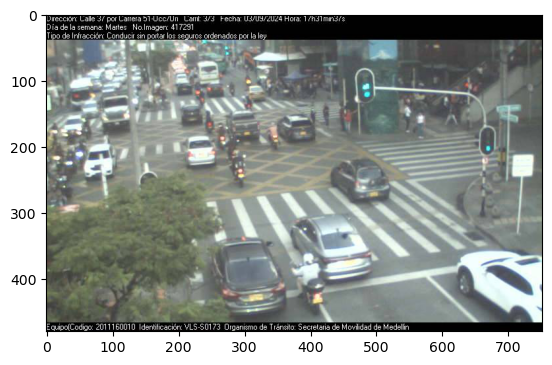

In [7]:
imgplot = plt.imshow(img)

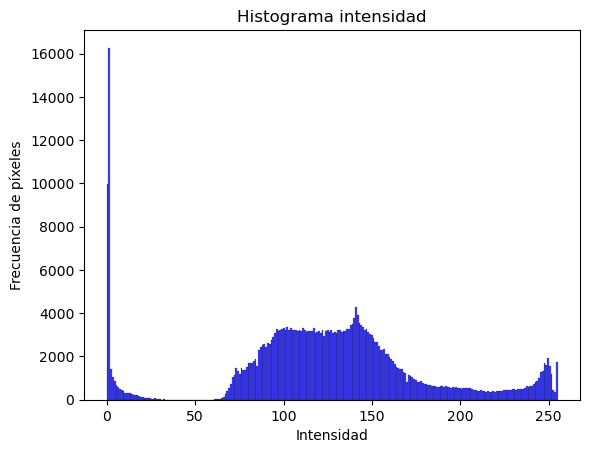

In [8]:
if img.ndim == 3:
    img = img.mean(axis=2)

#Histograma intensidad de pixeles
sns.histplot(img.ravel(), bins=256, kde=False, color='blue')
plt.title('Histograma intensidad')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia de píxeles')
plt.show()

### Idea: 
usar modelos preentrenados y precisos de detección de objetos para probar el dataset y ver cuáles imágenes serían o no clasificadas correctamente, de forma que se pueda determinar labels sobre la calidad de la imagen en sus condiciones. 

In [9]:
##### Modelo mobilenet-v2 ####


model_path = "mobilenet-v2-tensorflow1-100-128-classification-v2"

loaded_model = tf.saved_model.load(model_path, tags=['train'])

# MetaGraphs disponibles
print("MetaGraphs disponibles:", list(loaded_model.signatures.keys()))



MetaGraphs disponibles: ['image_classification', 'image_feature_vector', 'default']


In [16]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
#from six.moves.urllib.request import urlopen
#from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.17.0
The following GPU devices are available: 


In [25]:
#### Modelo faster-rcnn-inception-resnet-v2-tensorflow1- ####

### Funciones para el manejo de las imágenes ####


def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)
    plt.show()

def resize_local_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height))
    pil_image_rgb = pil_image.convert("RGB")
    
    # Save the resized image to a temporary file
    _, filename = tempfile.mkstemp(suffix=".jpg")
    with open(filename, 'wb') as temp_file:
        pil_image_rgb.save(temp_file, format="JPEG", quality=90)
    
    print(f"Image resized and saved to {filename}.")
    
    if display:
        display_image(pil_image_rgb)
    
    return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # Display text above the bounding box
    display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)  # Devuelve (x0, y0, x1, y1)
        text_width = bbox[2] - bbox[0]   # Ancho
        text_height = bbox[3] - bbox[1]  # Alto

        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                  25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image


Image resized and saved to C:\Users\Usuario\AppData\Local\Temp\tmp0jdvwlcf.jpg.


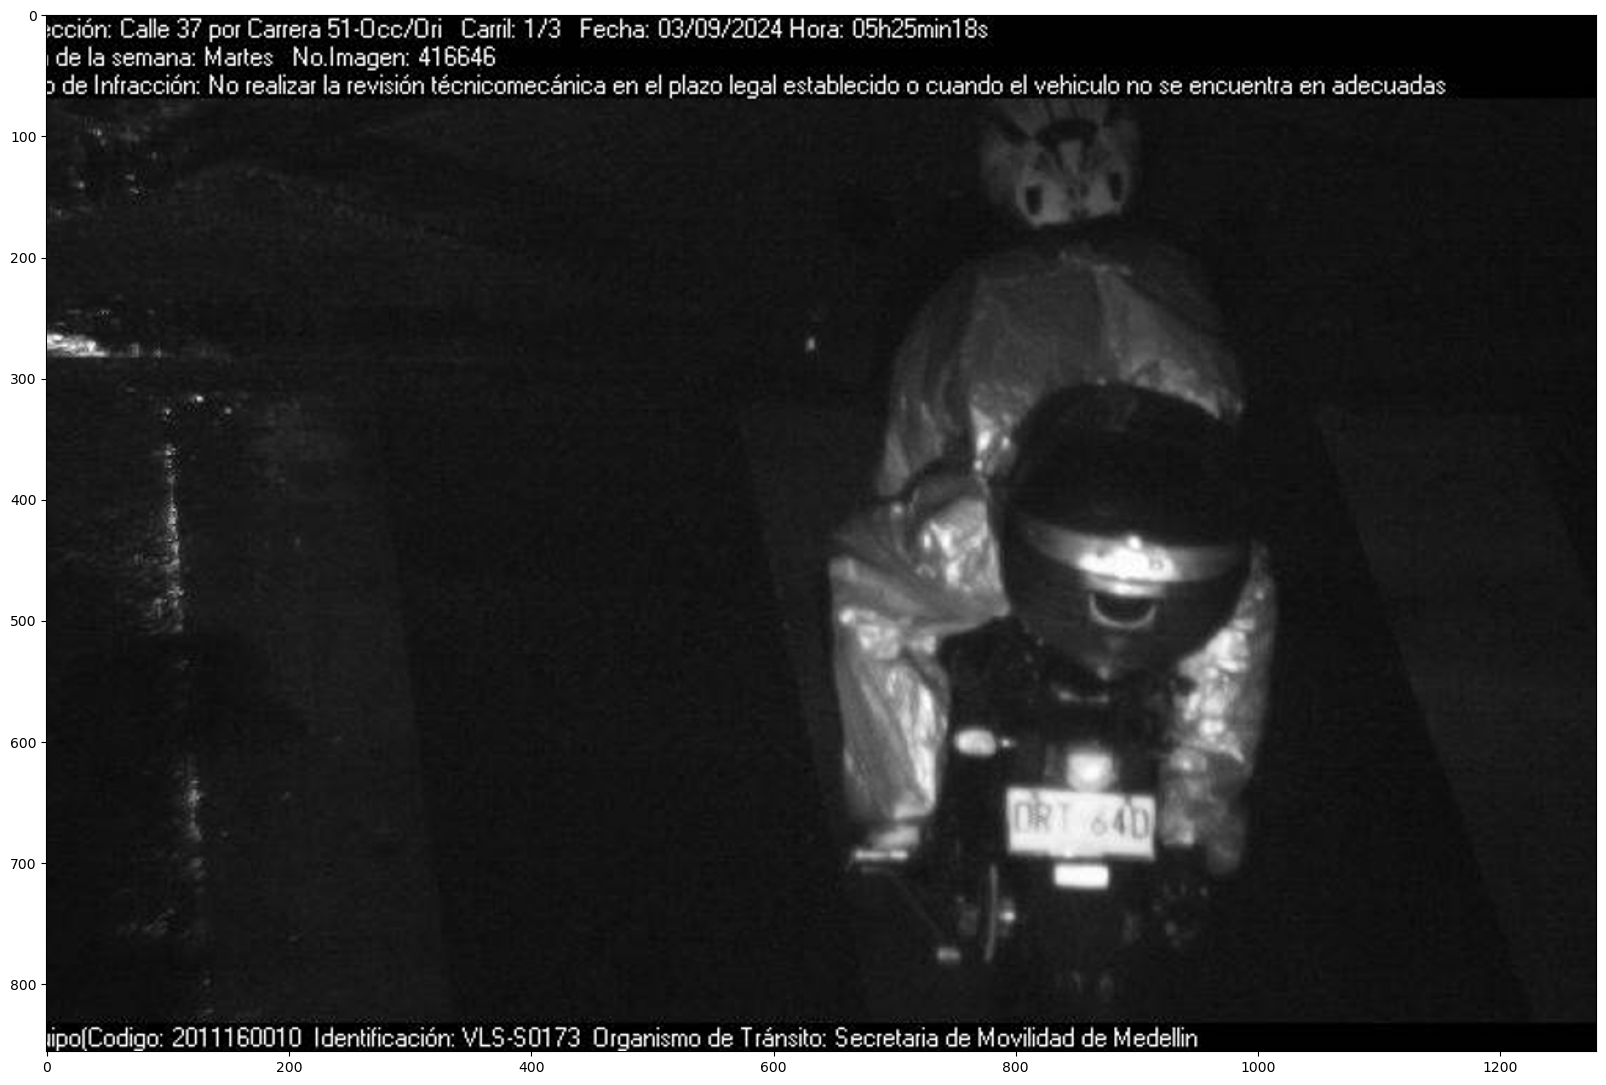

In [18]:
downloaded_image_path = resize_local_image('20240903/60_VLS-S0173_M3982023_01012011_M3982023_01012011_1_20240903_052518_416646_060_066_039_035_0168_DRT64D_ZT_00468_01544__1_184851_30003_1_00_10_00.jpg', 1280, 856, True)


In [19]:
module_handle = "faster-rcnn-inception-resnet-v2-tensorflow1-faster-rcnn-openimages-v4-inception-resnet-v2-v1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3) #convertir en tensor
  return img

In [21]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  5.1957361698150635
Font not found, using default font.


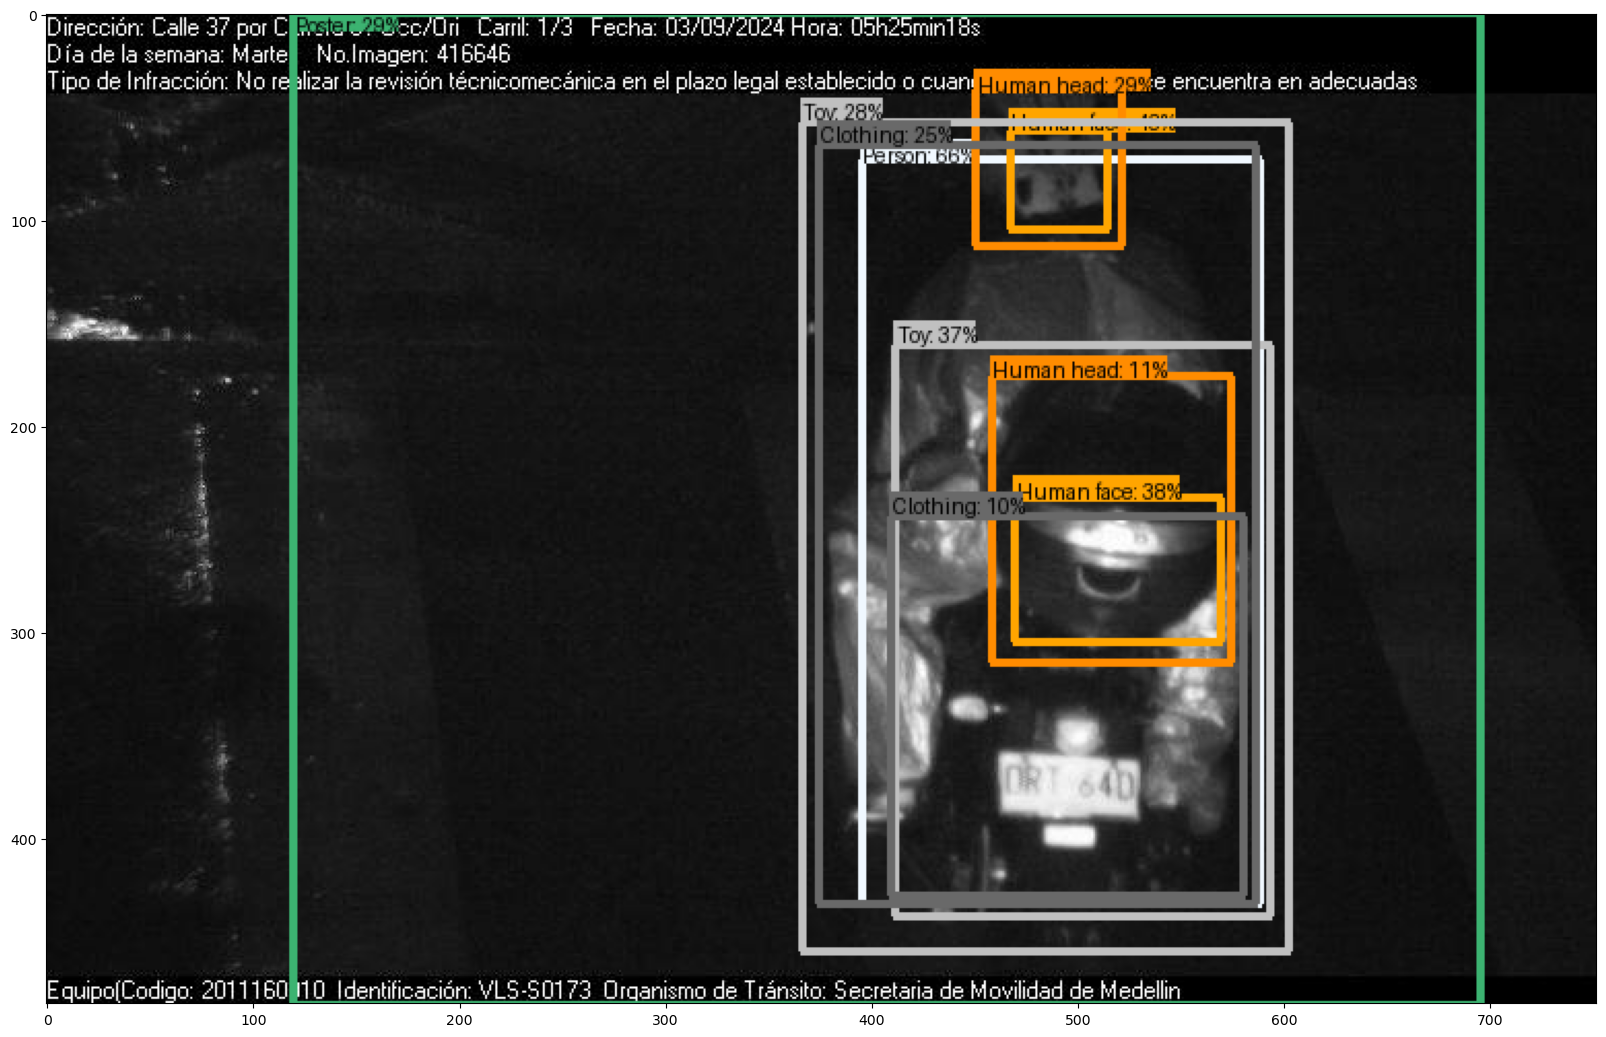

In [26]:
run_detector(detector, "20240903/60_VLS-S0173_M3982023_01012011_M3982023_01012011_1_20240903_052518_416646_060_066_039_035_0168_DRT64D_ZT_00468_01544__1_184851_30003_1_00_10_00.jpg")